In [1]:
from src.positioning.toa import toa_positioning
from itertools import permutations
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import os

In [2]:
dir_name = "Omni Spatial and Temporal Data"
data_dir = os.path.abspath("../../"+dir_name)
rx_power_tensor = sio.loadmat(os.path.join(data_dir, "all_rxpower_tensor"))['rx_power_tensor']
toa_tensor = sio.loadmat(os.path.join(data_dir, "all_toa_tensor"))['toa_tensor']
true_cord_tensor = sio.loadmat(os.path.join(data_dir, "all_true_tensor"))['true_cord_tensor']
zenith_aoa_tensor = sio.loadmat(os.path.join(data_dir, "all_zenith_tensor"))['zenith_aoa_tensor']
bs_coords = sio.loadmat(os.path.join(data_dir, "BScords"))
print(f"toa tensor shape is: {toa_tensor.shape}")
print(f"true coordinates tensor shape is: {true_cord_tensor.shape}")
print(f"zenith of arrival tensor shape is: {zenith_aoa_tensor.shape}")
print(f"The total number of trajectories is: {toa_tensor.shape[0]}")
print(f"The number of sample per trajectory is: {toa_tensor.shape[1]}")
tot_points = toa_tensor.shape[0]*toa_tensor.shape[1]
min_rx_cords = np.array([373.5530, 295.8490, 68.1720])
bs1_coord = bs_coords['bs1cords'] - min_rx_cords
bs2_coord = bs_coords['bs2cords'] - min_rx_cords
bs3_coord = bs_coords['bs3cords'] - min_rx_cords
bs4_coord = bs_coords['bs4cords'] - min_rx_cords
bss_coords = np.vstack((bs1_coord, bs2_coord, bs3_coord, bs4_coord))

toa tensor shape is: (50, 3000, 4)
true coordinates tensor shape is: (50, 3000, 3)
zenith of arrival tensor shape is: (50, 3000, 4)
The total number of trajectories is: 50
The number of sample per trajectory is: 3000


In [3]:
rx_power_tensor[rx_power_tensor == 0] = -np.infty
rx_power_tensor = 10 ** (0.1 * rx_power_tensor) 

BW = 400e6
k = 1.38e-23
NF = 10**(0.9)
T = 298
NoisePower = k*BW*NF*T
SNRs = rx_power_tensor/NoisePower
SNRs[SNRs==0.0] = 1e-25 # no paths to -250 dB SNR
print(np.sum((SNRs==1e-25)))

# adding Gaussian noise to the data
toa_tensor = toa_tensor + toa_tensor / np.sqrt(SNRs) * np.random.normal(0,1,size=toa_tensor.shape)
zenith_aoa_tensor = zenith_aoa_tensor + zenith_aoa_tensor / np.sqrt(SNRs) * np.random.normal(0,1,size=zenith_aoa_tensor.shape)

0


In [4]:
toa_tensor_r = np.reshape(toa_tensor, (tot_points, toa_tensor.shape[2]))
true_cord_tensor_r = np.reshape(true_cord_tensor, (tot_points, true_cord_tensor.shape[2]))
zenith_aoa_tensor_r = np.reshape(zenith_aoa_tensor, (tot_points, zenith_aoa_tensor.shape[2]))

# let's estimate the 3D UAV location for all the samples in the 50 trajectories
bs_idxs = range(4)
perm = list(permutations(bs_idxs, 3))
est_3d_coords = np.zeros((tot_points, 3))
idx_found = np.zeros((tot_points, 1))

for i, data_tuple in enumerate(zip(toa_tensor_r, zenith_aoa_tensor_r)):
    toa_array, zenith_array = data_tuple
    # convert degrees to radians
    zenith_array = zenith_array*np.pi/180.0
    k = 0
    pos_found = False
    est_3d_pos = 0
    while pos_found != True and k < len(perm):
        bs1_idx, bs2_idx, bs3_idx = perm[k]
        pos_found, est_3d_pos = toa_positioning(bss_coords[[bs1_idx,bs2_idx,bs3_idx],:],
                                 toa_array[[bs1_idx,bs2_idx,bs3_idx]],
                                 zenith_array[[bs1_idx,bs2_idx,bs3_idx]])
        k += 1

    idx_found[i] = int(pos_found)
    if pos_found:
        est_3d_coords[i,:] = est_3d_pos

print(f"Total positions not found={tot_points - np.sum(idx_found)}")
with open('../models/toa_estimated_noise.npy', 'wb') as f:
    np.save(f, est_3d_coords)

Total positions not found=76825.0


In [5]:
best_est_3d_coords = np.zeros((tot_points, 3))
idx_best_found = np.zeros((tot_points, 1))

for i, data_tuple in enumerate(zip(toa_tensor_r, zenith_aoa_tensor_r)):
    toa_array, zenith_array = data_tuple
    # convert degrees to radians
    zenith_array = zenith_array*np.pi/180.0
    k = 0
    pos_found = False
    est_3d_pos = None
    prev_est_3d_pos = [0,0,0]
    final_est_3d_pos = None
    prev_error = np.inf
    while k < len(perm):
        bs1_idx, bs2_idx, bs3_idx = perm[k]
        pos_found, est_3d_pos = toa_positioning(bss_coords[[bs1_idx,bs2_idx,bs3_idx],:],
                                 toa_array[[bs1_idx,bs2_idx,bs3_idx]],
                                 zenith_array[[bs1_idx,bs2_idx,bs3_idx]])
        if k > 1 and pos_found:
            est_3d_pos = np.array(est_3d_pos)
            prev_est_3d_pos = np.array(prev_est_3d_pos)
            error = np.sqrt(np.sum((est_3d_pos-prev_est_3d_pos)**2))
            if error < prev_error:
                prev_error = error
                best_est_3d_coords[i,:] = est_3d_pos
                prev_est_3d_pos = est_3d_pos
                idx_best_found[i] = int(pos_found)

        k += 1

print(f"Total positions not found={tot_points - np.sum(idx_best_found)}")
with open('../models/best_toa_estimated_noise.npy', 'wb') as f:
    np.save(f, best_est_3d_coords)

Total positions not found=76825.0


The percentage of location not found is [%]: 51.21666666666667


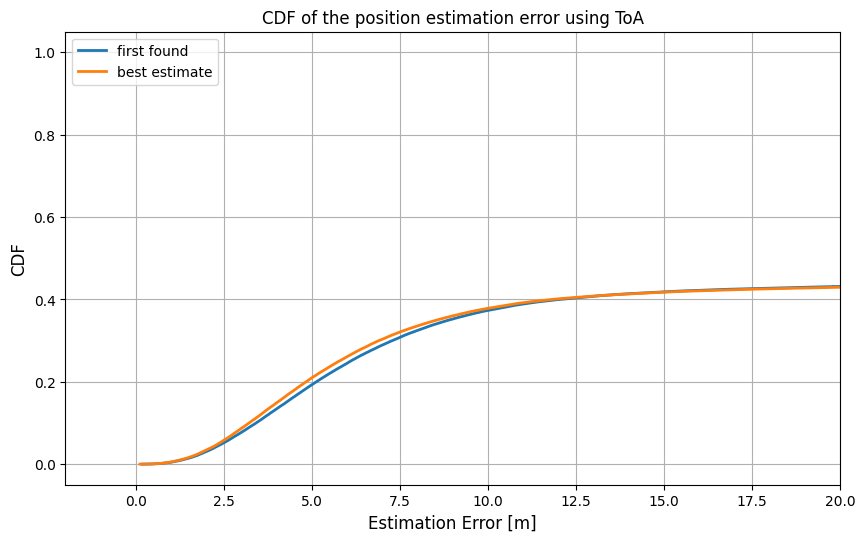

In [6]:
ratio = (tot_points - np.sum(idx_found))/tot_points
print(f"The percentage of location not found is [%]: {ratio*100.}")
# print results
error = np.sqrt(np.sum((true_cord_tensor_r - est_3d_coords)**2, axis=1))
best_error = np.sqrt(np.sum((true_cord_tensor_r - best_est_3d_coords)**2, axis=1))
plt.figure(figsize=(10,6), dpi=100)
plt.plot(np.sort(error), np.linspace(0,1,tot_points), linewidth=2, label="first found")
plt.plot(np.sort(best_error), np.linspace(0,1,tot_points), linewidth=2, label="best estimate")
plt.xlim([-2,20])
plt.ylabel("CDF", fontsize=12)
plt.xlabel("Estimation Error [m]", fontsize=12)
plt.title("CDF of the position estimation error using ToA")
plt.grid()
plt.legend(loc="upper left")
plt.savefig("./toa_error_cdf_noise.png")